<a href="https://colab.research.google.com/github/viki6666/Pytorch_learn/blob/master/Optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11


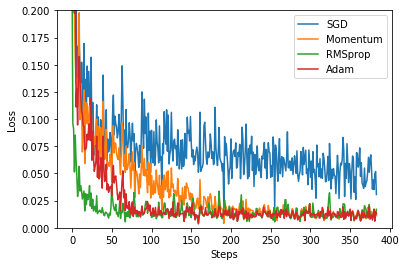

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
 
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
 
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(x.size()))
 
#plt.scatter(x.numpy(), y.numpy())
#plt.show()
 
 
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
 
 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
 
 
if __name__ == '__main__':
    net_SGD = Net()
    net_Momentum = Net()
    net_RMSprop = Net()
    net_Adam = Net()
    nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]
 
    opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
    opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
    opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
    opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.999))
    optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]
 
    loss_func = torch.nn.MSELoss()
    losses_his = [[], [], [], []]
 
    for epoch in range(EPOCH):
        print('Epoch:', epoch)
        for step, (b_x, b_y) in enumerate(loader):
            for net, opt, l_his in zip(nets, optimizers, losses_his):
                output = net(b_x)
                loss = loss_func(output, b_y)
                opt.zero_grad()
                loss.backward()
                opt.step()
                l_his.append(loss.data.numpy())
 
    labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
    for i, l_his in enumerate(losses_his):
        plt.plot(l_his, label = labels[i])
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 0.2))
    plt.show()

[随机梯度下降法](https://blog.csdn.net/chenjiale5/article/details/98074369)

0it [00:00, ?it/s]

9920512it [00:01, 9542412.77it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141608.33it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2331112.88it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50504.15it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
epoch:0,Train loss:0.730470597743988
epoch:1,Train loss:0.36438918113708496
epoch:2,Train loss:0.3212226331233978
epoch:3,Train loss:0.2960660457611084
epoch:4,Train loss:0.2763625979423523
使用时间:32.312254905700684


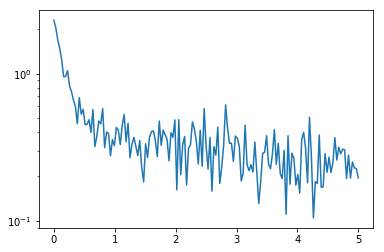

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

#随机梯度下降法，从0开始自己实现
def data_tf(x):
    x = np.array(x,dtype='float32')/255   #讲数据变成0-1之间
    x = (x-0.5)/0.5   #标准化
    x = x.reshape((-1,))  #拉平
    x = torch.from_numpy(x)
    return x

#载入数据集，声明定义的数据变换
train_set = MNIST('./data',train=True,transform=data_tf,download=True)
test_set = MNIST('./data',train=False,transform=data_tf,download=True)

#定义loss函数
criterion = nn.CrossEntropyLoss()

#定义梯度下降公式：lr学习率，parameters参数
def sgd_update(parameters,lr):
    for param in parameters:
        param.data = param.data - lr * param.grad.data

train_data = DataLoader(train_set,batch_size=64,shuffle=True)

net = nn.Sequential(
    nn.Linear(784,200),
    nn.ReLU(),
    nn.Linear(200,10)
)

#开始训练
losses1 = []
idx = 0

#计时开始
start = time.time()
for e in range(5):
    train_loss = 0
    for im,label in train_data:
        im = Variable(im)
        label = Variable(label)

        #向前传播
        out = net(im)
        loss = criterion(out,label)

        #反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(),0.01)

        #记录误差
        train_loss += loss.data
        if idx%30 == 0:
            losses1.append(loss.data)
        idx += 1

    print('epoch:{},Train loss:{}'.format(e,train_loss/len(train_data)))
end = time.time()
print('使用时间:{}'.format(end-start))

x_axis = np.linspace(0,5,len(losses1),endpoint=True)
plt.semilogy(x_axis,losses1,label='batch_size = 1')
plt.show()


In [3]:
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import MNIST

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5
    x = x.reshape((-1,))
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True)
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

criterion = nn.CrossEntropyLoss()
train_data = DataLoader(train_set, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

optimizer = torch.optim.SGD(net.parameters(),lr=1e-2,momentum=0.9)

losses = []
start = time.time()
idx = 0
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        if idx % 30 == 0:
            losses.append(loss.data)
        idx += 1

    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_data)))
end = time.time()
print('时间: {:.5f} s'.format(end - start))


epoch: 0, Train Loss: 0.360212
epoch: 1, Train Loss: 0.167414
epoch: 2, Train Loss: 0.122243
epoch: 3, Train Loss: 0.098851
epoch: 4, Train Loss: 0.085076
时间: 32.58808 s
